In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)

Load Cleaned Data

In [5]:
df = pd.read_parquet("../data/outputs/combined_dataset.parquet")
print(f"Dataset loaded successfully! Shape: {df.shape}")
print("Columns:", list(df.columns))
df.head(100)

Dataset loaded successfully! Shape: (43819782, 8)
Columns: ['latitude', 'longitude', 'dNBR', 'SPI', 'VCI', 'NDVI', 'severity', 'fire_name']


,latitude,longitude,dNBR,SPI,VCI,NDVI,severity,fire_name
0,38.869878,-121.142532,-0.113606,0.66689,0.462550,0.589904,Unburned,Caldor
1,38.869878,-121.142532,-0.113606,0.66689,0.462550,0.393256,Unburned,Caldor
2,38.869878,-121.142532,-0.113606,0.66689,0.462550,0.377522,Unburned,Caldor
3,38.869878,-121.142083,-0.010457,0.66689,0.462550,0.653064,Unburned,Caldor
4,38.869878,-121.142083,-0.010457,0.66689,0.462550,0.423746,Unburned,Caldor
...,...,...,...,...,...,...,...,...
95,38.869878,-121.128608,-0.263453,0.66689,0.472475,0.130871,Unburned,Caldor
96,38.869878,-121.128159,-0.135049,0.66689,0.472475,0.421275,Unburned,Caldor
97,38.869878,-121.128159,-0.135049,0.66689,0.472475,0.257036,Unburned,Caldor
98,38.869878,-121.128159,-0.135049,0.66689,0.472475,0.316968,Unburned,Caldor


Handle Missing Data

In [8]:
df = df.dropna(subset=["dNBR", "SPI", "VCI", "NDVI", "severity", "fire_name"])
print(f"After dropping missing rows: {df.shape[0]} samples remain.")

After dropping missing rows: 43819782 samples remain.


Encode Severity Labels

In [9]:
le = LabelEncoder()
df["severity_encoded"] = le.fit_transform(df["severity"])
print("Encoded severity classes:")
print(dict(zip(le.classes_, le.transform(le.classes_))))

Encoded severity classes:
{'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2), 'Unburned': np.int64(3)}


Feature and Target Definitions

In [10]:
features = ["dNBR", "SPI", "VCI", "NDVI"]
target = "severity_encoded"

X = df[features]
y = df[target]

Train/Test Split

In [11]:
train_fires = ["Caldor", "Camp", "Carr", "Creek", "Dixie", "Glass"]
test_fires = ["Troublesome", "Woolsey", "Thomas"]

train_df = df[df["fire_name"].isin(train_fires)]
test_df = df[df["fire_name"].isin(test_fires)]

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 31693542
Testing samples: 12126240


Feature Scaling

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train Baseline Models

In [13]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
lr_preds = lr.predict(X_test_scaled)
lr_probs = lr.predict_proba(X_test_scaled)[:, 1] if len(le.classes_) == 2 else None

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1] if len(le.classes_) == 2 else None

Evaluate Models


Logistic Regression Performance Metrics:
Accuracy:  1.000
Precision: 1.000
Recall:    1.000
F1 Score:  1.000

Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.99      0.99    248795
         Low       1.00      1.00      1.00    578218
    Moderate       0.98      0.99      0.98    149592
    Unburned       1.00      1.00      1.00  11149635

    accuracy                           1.00  12126240
   macro avg       0.99      0.99      0.99  12126240
weighted avg       1.00      1.00      1.00  12126240



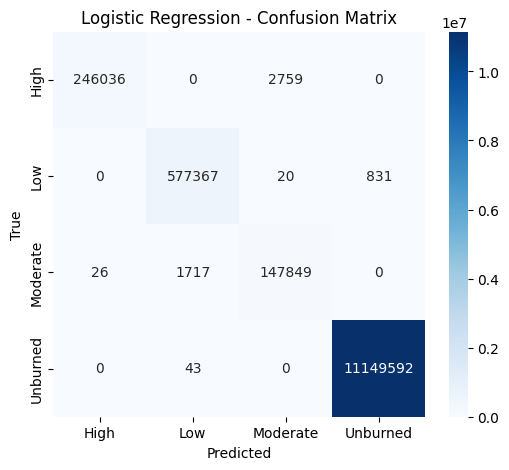


Random Forest Performance Metrics:
Accuracy:  1.000
Precision: 1.000
Recall:    1.000
F1 Score:  1.000

Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00    248795
         Low       1.00      1.00      1.00    578218
    Moderate       1.00      1.00      1.00    149592
    Unburned       1.00      1.00      1.00  11149635

    accuracy                           1.00  12126240
   macro avg       1.00      1.00      1.00  12126240
weighted avg       1.00      1.00      1.00  12126240



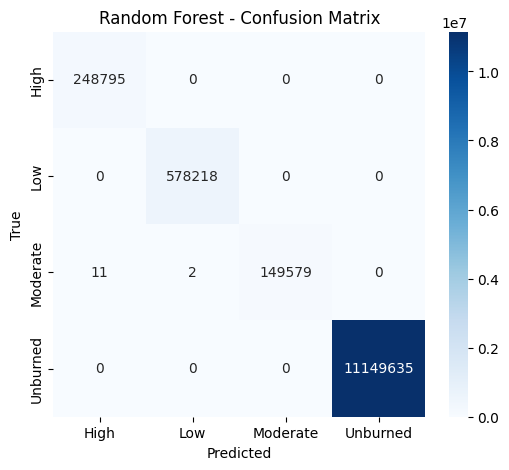

In [14]:
def evaluate_model(name, y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    auc_val = roc_auc_score(y_true, y_prob) if y_prob is not None and len(le.classes_) == 2 else np.nan

    print(f"\n{name} Performance Metrics:")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    if not np.isnan(auc_val):
        print(f"AUC:       {auc_val:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc_val}

lr_results = evaluate_model("Logistic Regression", y_test, lr_preds, lr_probs)
rf_results = evaluate_model("Random Forest", y_test, rf_preds, rf_probs)

Feature Importance (Random Forest)

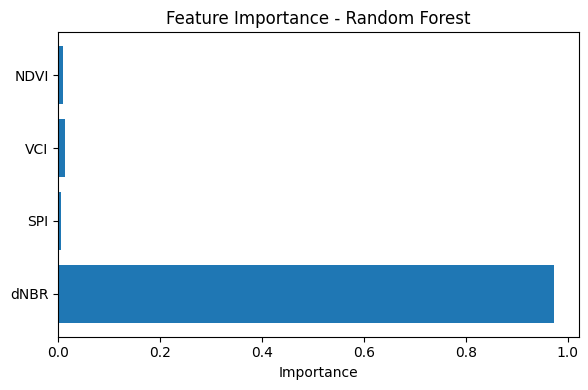

In [16]:
importances = rf.feature_importances_
plt.figure(figsize=(6,4))
plt.barh(features, importances)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

ROC Curve

In [18]:
if len(le.classes_) == 2:
    fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
    auc_lr = auc(fpr_lr, tpr_lr)
    auc_rf = auc(fpr_rf, tpr_rf)

    plt.figure(figsize=(6,5))
    plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC={auc_lr:.3f})")
    plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={auc_rf:.3f})")
    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Baseline Models")
    plt.legend()
    plt.show()

Save Results

In [19]:
results_df = pd.DataFrame([lr_results, rf_results])
results_df.to_csv("baseline_model_results.csv", index=False)
print("\nBaseline model results saved to baseline_model_results.csv")


Baseline model results saved to baseline_model_results.csv
